# FNC 8.3 — Exercises 1, 5, 6 (Python Notebook)

This notebook answers the **programming** exercises from **FNC 8.3 — Inverse iteration**.

- Written exercises **2–4** are answered in `习题解答/na_sol_datahub_8/main.tex`.

We implement **Function 8.3.3** (`inviter`) and the dynamic-shift variant from Exercise 6.


In [1]:
# If you're running locally and miss a dependency, uncomment the next line.
# %pip install --index-url https://pypi.org/simple numpy scipy matplotlib

import numpy as np
import matplotlib.pyplot as plt

from scipy import sparse
from scipy.sparse.linalg import splu, eigsh
from scipy import linalg


## Inverse iteration (Function 8.3.3)

Algorithm 8.3.2 solves a linear system

\[(A - sI) y_k = x_k\]

and normalizes by the infinity norm.


In [2]:
def normalize_inf(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    s = np.max(np.abs(x))
    if s == 0:
        raise ValueError('cannot normalize the zero vector')
    return x / s


def _factor_shifted(A, s):
    n = A.shape[0]
    if sparse.issparse(A):
        B = (A - s * sparse.identity(n, format='csc')).tocsc()
        return ('sparse', splu(B))
    B = np.asarray(A, dtype=float) - s * np.eye(n)
    lu, piv = linalg.lu_factor(B)
    return ('dense', (lu, piv))


def _solve_factored(kind, fact, rhs):
    if kind == 'sparse':
        return fact.solve(rhs)
    lu, piv = fact
    return linalg.lu_solve((lu, piv), rhs)


def inviter(A, s: float, numiter: int, *, x0=None, rng=None):
    '''Function 8.3.3 (shifted inverse iteration) with fixed shift s.'''
    n = A.shape[0]
    if x0 is None:
        rng = np.random.default_rng() if rng is None else rng
        x = rng.standard_normal(n)
    else:
        x = np.asarray(x0, dtype=float).reshape(n)

    x = normalize_inf(x)
    beta = np.empty(numiter, dtype=complex)

    kind, fact = _factor_shifted(A, s)

    for k in range(numiter):
        y = _solve_factored(kind, fact, x)
        m = int(np.argmax(np.abs(y)))
        if y[m] == 0:
            raise ZeroDivisionError('y[m] is zero; cannot form beta')
        beta[k] = x[m] / y[m] + s
        x = y / y[m]

    if np.all(np.isreal(beta)):
        beta = beta.real
    return beta, x


def inviter_dynamic(A, s0: float, numiter: int, *, x0=None, rng=None, tol=1e-12):
    '''Exercise 6(a): dynamic-shift inverse iteration (s updated to latest beta).'''
    n = A.shape[0]
    if x0 is None:
        rng = np.random.default_rng() if rng is None else rng
        x = rng.standard_normal(n)
    else:
        x = np.asarray(x0, dtype=float).reshape(n)

    x = normalize_inf(x)
    beta_list = []

    s = s0
    for _ in range(numiter):
        if not np.isfinite(s):
            break

        kind, fact = _factor_shifted(A, s)
        y = _solve_factored(kind, fact, x)
        m = int(np.argmax(np.abs(y)))
        if y[m] == 0:
            raise ZeroDivisionError('y[m] is zero; cannot form beta')

        b = x[m] / y[m] + s
        beta_list.append(b)
        x = y / y[m]

        if not np.isfinite(b):
            break
        if abs(b - s) <= tol * max(1.0, abs(b)):
            break
        s = b

    beta = np.array(beta_list, dtype=complex)
    if np.all(np.isreal(beta)):
        beta = beta.real
    return beta, x


## Exercise 1

Run 10 inverse-iteration steps for each `(A,s)` and compare the observed asymptotic error reduction to (8.3.4):

\[ \frac{\beta_{k+1}-\lambda_1}{\beta_k-\lambda_1} \to \frac{\lambda_1-s}{\lambda_2-s}. \]

Here `λ₁` is the eigenvalue closest to `s`, and `λ₂` is the second-closest.


Exercise 1 summary

(a) s = 1.0
  eigenvalues: [1.1 2.1]
  lambda1 (closest) = 1.1
  lambda2 (2nd)     = 2.1
  predicted ratio (8.3.4) = 0.09090909090909098
  observed median ratio (tail) = 0.0909090922381858
  beta_10 = 1.1000000000228216

(b) s = 2.0
  eigenvalues: [1.1 2.1]
  lambda1 (closest) = 2.1
  lambda2 (2nd)     = 1.1
  predicted ratio (8.3.4) = -0.11111111111111122
  observed median ratio (tail, 2-step) = 0.012345808386241903
  compare to pred^2 = 0.012345679012345703
  beta_10 = 2.0999999983825597

(c) s = 1.6
  eigenvalues: [1.1 2.1]
  lambda1 (closest) = 1.1
  lambda2 (2nd)     = 2.1
  predicted ratio (8.3.4) = -1.0
  note: |lambda1-s| = |lambda2-s| (no unique closest eigenvalue)
  observed median ratio (tail) = 0.6271293340433446
  beta_10 = 1.7271293340433447

(d) s = -0.33
  eigenvalues: [ 2.41421356 -0.41421356]
  lambda1 (closest) = -0.4142135623730951
  lambda2 (2nd)     = 2.414213562373095
  predicted ratio (8.3.4) = -0.030687685363769677
  observed median ratio (t

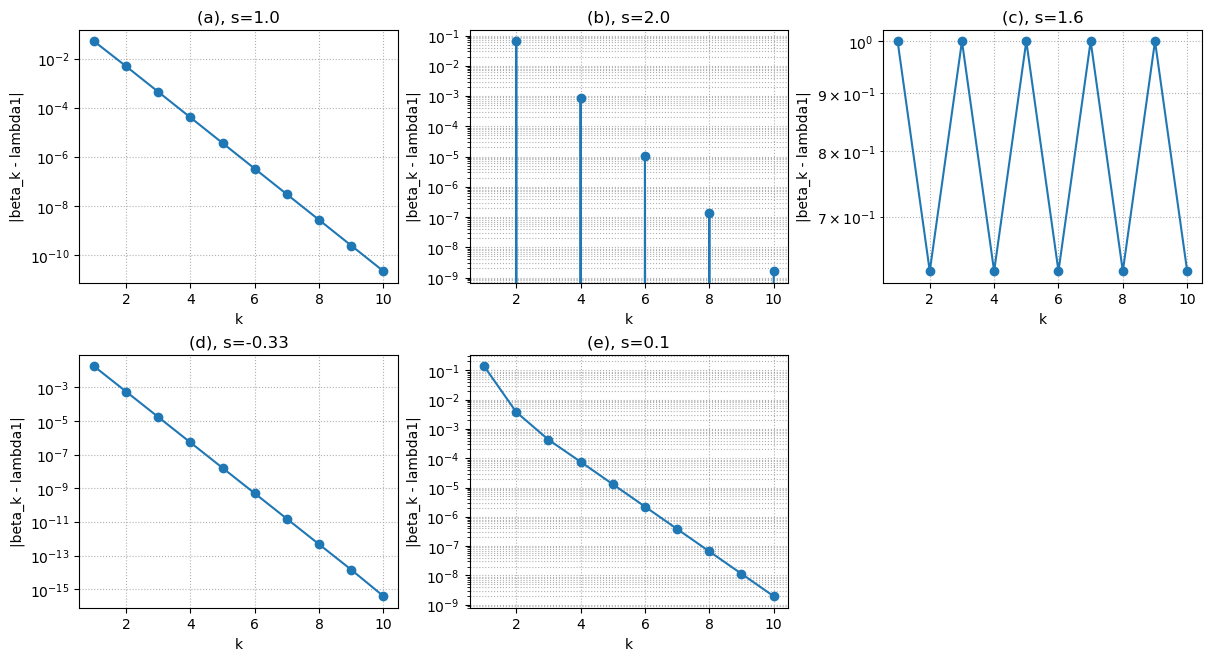

In [3]:
cases = {
    '(a)': (np.array([[1.1, 1.0], [0.0, 2.1]]), 1.0),
    '(b)': (np.array([[1.1, 1.0], [0.0, 2.1]]), 2.0),
    '(c)': (np.array([[1.1, 1.0], [0.0, 2.1]]), 1.6),
    '(d)': (np.array([[2.0, 1.0], [1.0, 0.0]]), -0.33),
    '(e)': (np.array([[6.0, 5.0, 4.0], [5.0, 4.0, 3.0], [4.0, 3.0, 2.0]]), 0.1),
}

rng = np.random.default_rng(123)

fig, axes = plt.subplots(2, 3, figsize=(12, 6.5), constrained_layout=True)
axes = axes.ravel()

print('Exercise 1 summary')

for ax, (name, (A, s)) in zip(axes, cases.items()):
    eigvals = np.linalg.eigvals(A)
    order = np.argsort(np.abs(eigvals - s))
    lam1 = eigvals[order[0]]
    lam2 = eigvals[order[1]]
    pred = (lam1 - s) / (lam2 - s)

    beta, _ = inviter(A, s, 10, rng=rng)
    err = beta - lam1

    threshold = 1e-12 * max(1.0, abs(lam1))

    ratios1 = np.full_like(err[1:], np.nan, dtype=float)
    np.divide(err[1:], err[:-1], out=ratios1, where=np.abs(err[:-1]) > threshold)
    mask1 = np.isfinite(ratios1) & (np.abs(err[1:]) > threshold) & (np.abs(err[:-1]) > threshold)
    r1 = ratios1[mask1]
    tail1 = r1[-3:] if r1.size >= 3 else r1
    obs = np.median(tail1) if tail1.size else np.nan
    obs_kind = '1-step'

    if not np.isfinite(obs):
        ratios2 = np.full_like(err[2:], np.nan, dtype=float)
        np.divide(err[2:], err[:-2], out=ratios2, where=np.abs(err[:-2]) > threshold)
        mask2 = np.isfinite(ratios2) & (np.abs(err[2:]) > threshold) & (np.abs(err[:-2]) > threshold)
        r2 = ratios2[mask2]
        tail2 = r2[-3:] if r2.size >= 3 else r2
        obs = np.median(tail2) if tail2.size else np.nan
        obs_kind = '2-step'

    ax.semilogy(np.arange(1, 11), np.abs(err), marker='o')
    ax.set_title(f'{name}, s={s}')
    ax.set_xlabel('k')
    ax.set_ylabel('|beta_k - lambda1|')
    ax.grid(True, which='both', ls=':')

    print()
    print(name, 's =', s)
    print('  eigenvalues:', eigvals)
    print('  lambda1 (closest) =', lam1)
    print('  lambda2 (2nd)     =', lam2)
    print('  predicted ratio (8.3.4) =', pred)
    if np.isclose(abs(lam1 - s), abs(lam2 - s)):
        print('  note: |lambda1-s| = |lambda2-s| (no unique closest eigenvalue)')
    if obs_kind == '1-step':
        print('  observed median ratio (tail) =', obs)
    else:
        print('  observed median ratio (tail, 2-step) =', obs)
        print('  compare to pred^2 =', pred**2)
    print('  beta_10 =', beta[-1])

for j in range(len(cases), len(axes)):
    axes[j].axis('off')

plt.show()


## Exercise 5 — `poisson(n)` membrane matrix

We use the 2D five-point Laplacian `poisson(n)` (size `n^2 × n^2`), scaled by `(n+1)^2`.

- (a) find the eigenvalue `λ_m` closest to 0 for `n=10,15,20,25`.
- (b) run 50 steps of inverse iteration with shift `s=0` and plot `|β_k-λ_m|`.
- (c) visualize the mode shape for `n=25`.


Exercise 5(a): eigenvalue closest to 0
n=10: lambda_m ~ 1.960540077058e+01
n=15: lambda_m ~ 1.967587286709e+01
n=20: lambda_m ~ 1.970242253887e+01
n=25: lambda_m ~ 1.971520443886e+01
\nExercise 5(b): inverse iteration convergence (s=0)


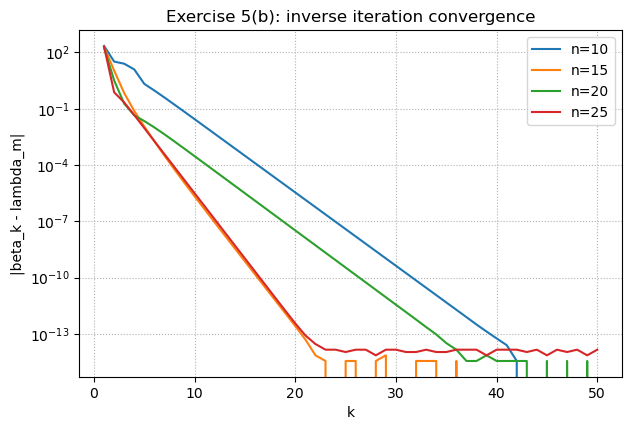

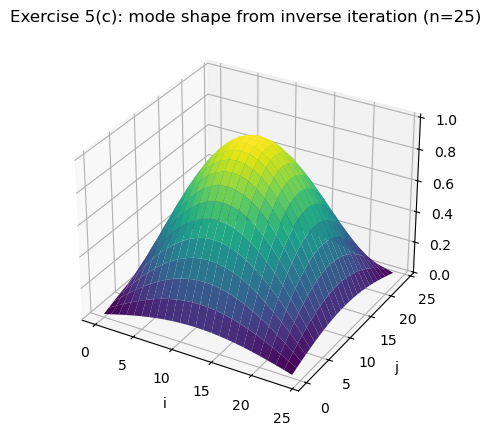

In [4]:
def poisson_2d(n: int) -> sparse.csc_matrix:
    T = sparse.diags(
        diagonals=[-np.ones(n - 1), 2 * np.ones(n), -np.ones(n - 1)],
        offsets=[-1, 0, 1],
        format='csc',
    )
    I = sparse.identity(n, format='csc')
    P = sparse.kron(I, T) + sparse.kron(T, I)
    return ((n + 1) ** 2) * P


ns = [10, 15, 20, 25]
lam_m = {}

print('Exercise 5(a): eigenvalue closest to 0')
for n in ns:
    A = poisson_2d(n).astype(float)
    lam = float(eigsh(A, k=1, sigma=0, which='LM', return_eigenvectors=False)[0])
    lam_m[n] = lam
    print(f'n={n:2d}: lambda_m ~ {lam:.12e}')


print('\\nExercise 5(b): inverse iteration convergence (s=0)')
plt.figure(figsize=(7, 4.5))
rng = np.random.default_rng(2025)
for n in ns:
    A = poisson_2d(n).astype(float)
    beta, _ = inviter(A, s=0.0, numiter=50, rng=rng)
    err = np.abs(beta - lam_m[n])
    plt.semilogy(np.arange(1, 51), err, label=f'n={n}')

plt.xlabel('k')
plt.ylabel('|beta_k - lambda_m|')
plt.title('Exercise 5(b): inverse iteration convergence')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.show()


# (c) visualize eigenvector for n=25
n = 25
A = poisson_2d(n).astype(float)
beta, v = inviter(A, s=0.0, numiter=50, rng=np.random.default_rng(7))
V = v.real.reshape(n, n)

x = np.arange(n)
y = np.arange(n)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, V, cmap='viridis', linewidth=0, antialiased=True)
ax.set_title('Exercise 5(c): mode shape from inverse iteration (n=25)')
ax.set_xlabel('i')
ax.set_ylabel('j')
plt.show()


## Exercise 6 — Dynamic shifting

We apply the dynamic-shift inverse iteration from part (a) to a triangular matrix with known eigenvalues.


In [5]:
def make_diag_superdiag(diag, superdiag):
    diag = np.asarray(diag, dtype=float)
    n = diag.size
    A = np.diag(diag)
    A[np.arange(n - 1), np.arange(1, n)] = np.asarray(superdiag, dtype=float)
    return A


def dynamic_shift_report(A, s0, numiter=12, label=''):
    beta, _ = inviter_dynamic(A, s0, numiter=numiter, rng=np.random.default_rng(0))

    eigs = np.diag(A)
    lam = float(eigs[np.argmin(np.abs(eigs - beta[-1]))])

    err = np.abs(beta - lam)
    floor = np.finfo(float).eps * max(1.0, abs(lam))
    logerr = np.log10(np.maximum(err, floor))

    print(f'\\n{label}  initial shift s0={s0}')
    print('  converged eigenvalue ~', beta[-1])
    print('  nearest diagonal eigenvalue =', lam)
    print('  k  log10|beta_k - lambda|')
    for k, le in enumerate(logerr, start=1):
        print(f'  {k:2d}  {le: .6f}')

    return beta, lam, err


n = 100
diag = (np.arange(1, n + 1) ** 2)
superdiag = np.random.default_rng(123).random(n - 1)
A = make_diag_superdiag(diag, superdiag)

beta1, lam1, err1 = dynamic_shift_report(A, s0=920.0, numiter=12, label='(b)')

beta2, lam2, err2 = dynamic_shift_report(A, s0=500.0, numiter=12, label='(c)')


\n(b)  initial shift s0=920.0
  converged eigenvalue ~ 961.0
  nearest diagonal eigenvalue = 961.0
  k  log10|beta_k - lambda|
   1  -1.126377
   2  -4.052456
   3  -9.904876
   4  -12.670836
\n(c)  initial shift s0=500.0
  converged eigenvalue ~ 484.0
  nearest diagonal eigenvalue = 484.0
  k  log10|beta_k - lambda|
   1  -1.350800
   2  -4.353487
   3  -10.359959
   4  -12.968714
